## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 4 - Estratégias de Treinamento e Transferência de Aprendizado</span>

#### <span style="color:darkred">**Parte 2: Aumentação de Dados e Transferência de Aprendizado**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# selecionamos 20% para treinamento (~5200 imagens) e 10% para validacao
(train_ds, validation_ds), info = tfds.load(
    "malaria",
    split=["train[0%:20%]", "train[20%:30%]"],
    as_supervised=True, 
    with_info=True
)

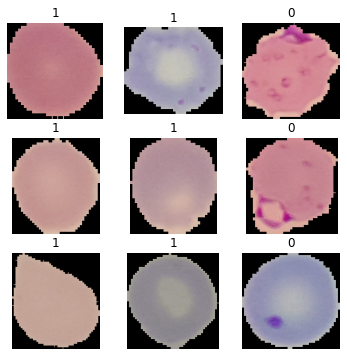

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [3]:
print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (128, 128)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [4]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

---

### Data Augmentation: 
#### funciona como uma camada de pré-processamento, gerando transformações aleatórias na imagem de entrada. 

Ao longo das épocas é responsável pela perturbação da entrada.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

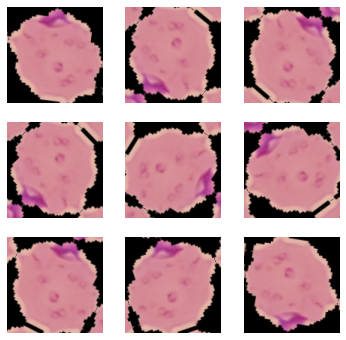

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[2], 0), training=True
        )
        plt.imshow(augmented_image[0].numpy())
        plt.axis("off")


--- 
### Carregando a CNN "MobileNet V2" para ser usada como "backbone" da solução

Tentativa 1: pesos inicializados aleatoriamente

carregamos `include_top=False` pois não queremos a última camada (top), especifica da ImageNet


In [7]:
base_model_random = tf.keras.applications.MobileNetV2(
    weights=None,
    input_shape=(128, 128, 3),
    include_top=False
)

# Permitir treinamento do modelo carregado
base_model_random.trainable = True

# Com base na MobileNetV2 vamos criar nosso modelo
# definimos o tamanho da entrada
inputs = keras.Input(shape=(128, 128, 3))
# aplicamos a transformacao da imagem de entrada
x = data_augmentation(inputs)

# Depois da "aumentacao de dados", temos o modelo base
x = base_model_random(x, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1)(x)

model_random = keras.Model(inputs, outputs)

model_random.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_______________________________________

#### Compilando e treinando o modelo a partir de pessos aleatórios

In [8]:
seed(1)
set_seed(2)

model_random.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
rand_hist = model_random.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
173/173 [==============================] - 28s 159ms/step - loss: 6.8492 - binary_accuracy: 0.5319 - val_loss: 7.1781 - val_binary_accuracy: 0.5230
Epoch 2/20
173/173 [==============================] - 23s 132ms/step - loss: 7.1650 - binary_accuracy: 0.5229 - val_loss: 7.8930 - val_binary_accuracy: 0.4657
Epoch 3/20
173/173 [==============================] - 23s 132ms/step - loss: 7.4747 - binary_accuracy: 0.5083 - val_loss: 7.7270 - val_binary_accuracy: 0.4933
Epoch 4/20
173/173 [==============================] - 23s 132ms/step - loss: 7.5057 - binary_accuracy: 0.5078 - val_loss: 7.7270 - val_binary_accuracy: 0.4933
Epoch 5/20
173/173 [==============================] - 23s 132ms/step - loss: 7.5057 - binary_accuracy: 0.5078 - val_loss: 7.7270 - val_binary_accuracy: 0.4933
Epoch 6/20
173/173 [==============================] - 23s 132ms/step - loss: 7.5057 - binary_accuracy: 0.5078 - val_loss: 7.7270 - val_binary_accuracy: 0.4933
Epoch 7/20
173/173 [==========================

--- 
### Carregando a CNN "MobileNet V2" com pesos pré-treinados

Tentativa 2: uso de pesos treinados na imagenet


In [9]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# Tornamos o modelo base não treinável, "congelando" os parâmetros
base_model.trainable = False

# Nosso modelo como anteriormente
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs) 

# Incluindo a MobileNetV2 com parametros pré-treinados, mas ainda não treinável
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1)(x) # essa será a única camada treinável
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
________________________________________

#### Passo 1: treinar apenas a camada de saída (softmax)


In [10]:
seed(1)
set_seed(2)

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 12
pt_hist1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/12
173/173 [==============================] - 9s 55ms/step - loss: 3.2058 - binary_accuracy: 0.7026 - val_loss: 2.7276 - val_binary_accuracy: 0.7347
Epoch 2/12
173/173 [==============================] - 8s 49ms/step - loss: 2.2284 - binary_accuracy: 0.7843 - val_loss: 1.6573 - val_binary_accuracy: 0.8207
Epoch 3/12
173/173 [==============================] - 8s 49ms/step - loss: 3.7618 - binary_accuracy: 0.7039 - val_loss: 1.2782 - val_binary_accuracy: 0.8530
Epoch 4/12
173/173 [==============================] - 8s 49ms/step - loss: 2.3443 - binary_accuracy: 0.7906 - val_loss: 1.6930 - val_binary_accuracy: 0.8290
Epoch 5/12
173/173 [==============================] - 8s 49ms/step - loss: 2.3458 - binary_accuracy: 0.8004 - val_loss: 1.4270 - val_binary_accuracy: 0.8635
Epoch 6/12
173/173 [==============================] - 8s 49ms/step - loss: 1.9635 - binary_accuracy: 0.8249 - val_loss: 1.6224 - val_binary_accuracy: 0.8515
Epoch 7/12
173/173 [==============================] - 8s 4

#### Passo 2: ajuste fino do restante dos parâmetros

Executamos mais algumas épocas para tentar melhorar as outras camadas

In [11]:
# des-congelando o modelo base, permitindo ser treinável
base_model.trainable = True

# note a diferença no summary
model.summary()

# aqui definimos um passo/learning rate bem pequeno para o ajuste-fino
model.compile(
    optimizer=keras.optimizers.Adam(0.00001), 
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 8
pt_hist2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_______________________________________

173/173 [==============================] - 27s 153ms/step - loss: 2.3964 - binary_accuracy: 0.8237 - val_loss: 1.5818 - val_binary_accuracy: 0.8762
Epoch 2/8
173/173 [==============================] - 26s 149ms/step - loss: 1.4044 - binary_accuracy: 0.8926 - val_loss: 1.2378 - val_binary_accuracy: 0.9129
Epoch 3/8
173/173 [==============================] - 26s 148ms/step - loss: 1.3948 - binary_accuracy: 0.8977 - val_loss: 0.8498 - val_binary_accuracy: 0.9368
Epoch 4/8
173/173 [==============================] - 26s 149ms/step - loss: 0.8433 - binary_accuracy: 0.9392 - val_loss: 0.6974 - val_binary_accuracy: 0.9514
Epoch 5/8
173/173 [==============================] - 26s 148ms/step - loss: 0.9236 - binary_accuracy: 0.9263 - val_loss: 1.0590 - val_binary_accuracy: 0.9187
Epoch 6/8
173/173 [==============================] - 26s 148ms/step - loss: 0.8021 - binary_accuracy: 0.9370 - val_loss: 6.8145 - val_binary_accuracy: 0.5383
Epoch 7/8
173/173 [==============================] - 26s 148ms

Comparando o histórico das duas abordagens

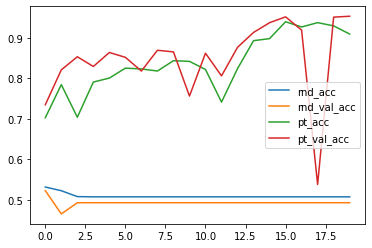

In [12]:
pt_tra_hist = np.concatenate((pt_hist1.history['binary_accuracy'], pt_hist2.history['binary_accuracy']), axis=None)
pt_val_hist = np.concatenate((pt_hist1.history['val_binary_accuracy'], pt_hist2.history['val_binary_accuracy']), axis=None)

plt.plot(rand_hist.history['binary_accuracy'])
plt.plot(rand_hist.history['val_binary_accuracy'])
plt.plot(pt_tra_hist)
plt.plot(pt_val_hist)
plt.legend(['rnd_acc','rnd_val_acc','pt_acc','pt_val_acc'])

--- 
### Obtendo features a partir da CNN "MobileNet V2" com pesos pré-treinados

Esse processo não necessita de treinamento da rede

Vamos obter a saída dessa rede, sem incluir a camada de predição (softmax).
Para obter features, incluímos uma nova camada, de Global Pooling e definimos essa camada como sendo a de saída do modelo.

Aqui também não incluimos o "topo" da rede, cujas camadas dependem de uma entrada de tamanho igual a da ImageNet (224x224) e saída com 1000 classes.


In [ ]:
base_model_extraction = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# obtemos a camada de saída do modelo carregado (última camada pois não incluímos o topo da rede)
base_output = base_model_extraction.layers[-1].output

# para evitar uma dimensionalidade alta, definimos uma nova camada de saída
feat_layer = keras.layers.GlobalAveragePooling2D()(base_output)

# montamos um novo modelo com a entrada do pré-treinado, e saída criada acima
model3 = keras.models.Model(base_model_extraction.inputs, feat_layer)
# descomente para ver como ficou o modelo final
# model3.summary()

# passando os exemplos de treinamento pela rede sem treinamento
# o "predict" vai nos dar a saída programada, obtida da GlobalAveragePooling2D
features_train = np.array(model3.predict(train_ds))
print('\tDados x features obtidas treinamento: ', features_train.shape)


	Dados x features obtidas treinamento:  (5512, 1280)


As features obtidas podem ser utilizadas para treinar classificadores não profundos ou como índices de sistemas de recuperação baseada em conteúdo
